In [1]:

import numpy
numpy.__version__


'1.21.0'

In [2]:
import mesa

In [3]:
import random

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import matplotlib.pyplot as plt

In [6]:
from scipy.optimize import fmin
import numpy as np

def f(x, EA, EB, VA, VB, covAB):

    return -(EA * x[0] + x[1] * EB + x[2] * 0.05 - 0.025 * 100 * (VA * x[0] ** 2 +  2 * covAB * x[0] * x[1] + VB * x[1] ** 2))

fmin(f, [10, 10, 10], args=(1, 1, 0.1, 0.3, 0.01), maxiter=100, disp=0, full_output = False)



array([2.13872739e+02, 9.40772406e+01, 1.44169670e+06])

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
 class MyRandomActivation(mesa.time.RandomActivation):
        def __init__(self, model):
            super().__init__(model)
        
        def step(self, a, b):
            price = [None, None]
            for agent in self.agent_buffer(shuffled=True):
                ans = agent.step(a, b)
                if ans[0] != None:
                    price[0] = ans[0]
                if ans[1] != None:
                    price[1] = ans[1]
            self.steps += 1
            self.time += 1
            return price

In [21]:

def compute_priceA(model):
    return model.price[0]

def compute_priceB(model):
    return model.price[1]

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model, begin_welth, name, CovAB=0.01, risk_free=0.05):
        super().__init__(unique_id, model)
        self.wealth = begin_welth
        self.supply = dict()
        self.supply['StockA'] = [5, 0.5]
        self.supply['StockB'] = [5, 0.02]
        self.stock = dict()
        self.stock['StockA'] = 20
        self.stock['StockB'] = 20
        self.risk_free = risk_free
        self.CovAB = CovAB
        self.utility = random.uniform(1, 110)
        self.name = 'Def'
    
    def f(self, x, EA, EB, VA, VB):
        Er = EA * x[0] + x[1] * EB + x[2] * self.risk_free
        Vr = (VA * x[0] ** 2 +  2 * self.CovAB * x[0] * x[1] + VB * x[1] ** 2)
        return -( Er - 0.025 * self.utility * Vr)

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    @staticmethod
    def deal(first, second, price, num, Stock):
        first.wealth += price * num
        second.wealth -= price * num
        first.stock[Stock] -= num
        second.stock[Stock] += num
        first.supply[Stock][0] += num
        second.supply[Stock][0] -= num
        
        
    @staticmethod
    def want_to_buy(first, second, Stock):
        first_supply, first_price = first.supply[Stock]
        second_supply, second_price = second.supply[Stock]
           
        price = None
        num = min(abs(first_supply), abs(second_supply))
        if first_supply > 0 and second_supply < 0 and first_price > second_price:
            price = (first_price + second_price) / 2
            first.deal(first, second, price, num, Stock)
            
            
        elif first_supply < 0 and second_supply > 0 and first_price < second_price:
            price = (first_price + second_price) / 2
            first.deal(second, first, price, num, Stock)
        return price    
                
    
    
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        price = [None, None]
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            price = [self.want_to_buy(self, other, 'StockA'), self.want_to_buy(self, other, 'StockB')]
        return price
        

    

class NoisyTrader(MoneyAgent):
  
    def __init__(self, unique_id, model, begin_welth, name):
        super().__init__(unique_id, model, begin_welth, name)
        self.utility = random.uniform(0, 10)
        
              
    def step(self, stockA, stockB):
        self.move()
        best = fmin(self.f, [1, 1, 1], args=(stockA[0], stockB[0], stockA[1], stockB[1]), disp = 0)
        wantA = best[0] - self.stock['StockA'] 
        wantB = best[1] - self.stock['StockB'] 
        wealth = best[2] - self.wealth
        p = random.uniform(0.1, 10)
        self.supply['StockB'] = [wantB, p]
        self.supply['StockA'] = [wantA, p]
        price = self.give_money()
        return price
        
    
    
    
class Investor(MoneyAgent):
  
    def __init__(self, unique_id, model, begin_welth, name):
        super().__init__(unique_id, model, begin_welth, name)
        self.utility = random.uniform(20, 40)
        
              
    def step(self, stockA, stockB):
        self.move()
        best = fmin(self.f, [1, 1, 1], args=(stockA[0], stockB[0], stockA[1], stockB[1]), disp = 0)
        wantA = best[0] - self.stock['StockA'] 
        wantB = best[1] - self.stock['StockB'] 
        wealth = best[2] - self.wealth
        p = random.uniform(0.1, 19)
        self.supply['StockB'] = [wantB, p]
        self.supply['StockA'] = [wantA, p]
        price = self.give_money()
        return price
        

    
class HFT(MoneyAgent):
  
    def __init__(self, unique_id, model, begin_welth, name):
        super().__init__(unique_id, model, begin_welth, name)
        self.utility = random.uniform(90, 100)
        
              
    def step(self, stockA, stockB):
        self.move()
        best = fmin(self.f, [1, 1, 1], args=(stockA[0], stockB[0], stockA[1], stockB[1]), disp = 0)
        wantA = best[0] - self.stock['StockA'] 
        wantB = best[1] - self.stock['StockB'] 
        wealth = best[2] - self.wealth
        p = random.uniform(0.1, 10)
        self.supply['StockB'] = [wantB, p]
        self.supply['StockA'] = [wantA, p]
        price = self.give_money()
        return price
    
    
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = MyRandomActivation(self)
        self.A = [1, 0.1]
        self.B = [1, 0.1]
        self.Cov = 0.01
        self.n_iter = 1
        self.risk_free = 0.05
        self.prev_price = [0, 0]
        self.price = [1, 0]
        self.history_price = []
        self.agents = []

        # Create agents
        for i in range(0, self.num_agents, 3):
            begin_welth = 20
            begin_welth_2 = 100
            begin_welth_3 = 50
            a = NoisyTrader(i, self, begin_welth, 'NT')
            b = HFT(i+1, self, begin_welth_2, 'HFT')
            c = Investor(i+2, self, begin_welth_3, 'I')
            self.schedule.add(a)
            self.schedule.add(b)
            self.schedule.add(c)
            self.agents.append(a)
            self.agents.append(b)
            self.agents.append(c)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            x1 = self.random.randrange(self.grid.width)
            y1 = self.random.randrange(self.grid.height)
            x2 = self.random.randrange(self.grid.width)
            y2 = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            self.grid.place_agent(b, (x1, y1))
            self.grid.place_agent(c, (x2, y2))

        self.datacollector = mesa.DataCollector(
            model_reporters={"PriceA": compute_priceA, "PriceB": compute_priceB}, agent_reporters={"Wealth": "wealth"}
        )
        
    
    
    
    def ChangeExpected(self):
        n = self.n_iter
        muA = self.A[0]
        muB = self.B[0] 
        dif = self.price[0] - self.prev_price[0]
        self.A[0] = 1/n * (dif + (n - 1) * muA)
        self.A[1] = 1/n * (dif ** 2 + (n - 1) * (muA ** 2 + self.A[1])) - self.A[0] ** 2
        self.B[0] = 1/n * (dif + (n - 1) * muB)
        self.B[1] = 1/n * (dif ** 2 + (n - 1) * (muB ** 2 + self.B[1])) - self.B[0] ** 2
        self.n_iter += 1
        
        
    def step(self):
        self.datacollector.collect(self)
        new_price = self.schedule.step(self.A, self.B)
        self.prev_price = self.price
        for i in [0, 1]:
            if new_price[i] != None:
                self.price[i] = new_price[i]
        self.ChangeExpected()

In [22]:

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        print(type(agent))
        if isinstance(agent, HFT):
            portrayal["Color"] = "red"
            portrayal["Layer"] = 0
        elif isinstance(agent, Investor):
            portrayal["Color"] = "blue"
            portrayal["Layer"] = 1
            portrayal["r"] = 0.4
        else:
            portrayal["Color"] = "yellow"
            portrayal["Layer"] = 2 
            portrayal["r"] = 0.3
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal


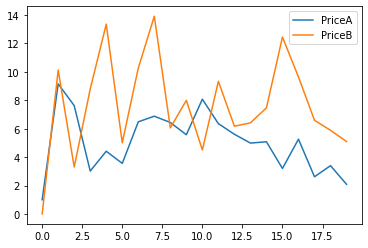

In [23]:
model = MoneyModel(80, 10, 10)
for i in range(20):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [24]:
grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
chart = mesa.visualization.ChartModule([{"Label": "PriceB",
                      "Color": "Black"}],
                    data_collector_name='datacollector')
price = mesa.visualization.ChartModule([{"Label": "PriceA",
                      "Color": "Black"}],
                    data_collector_name='datacollector')
server = mesa.visualization.ModularServer(MoneyModel,
                       [grid, chart, price],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 757
# The default
server.launch()

Interface starting at http://127.0.0.1:757


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
<class '__main__.Investor'>
<class '__main__.Investor'>
<class '__main__.Investor'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.Investor'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.NoisyTrader'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__main__.Investor'>
<class '__main__.HFT'>
<class '__main__.NoisyTrader'>
<class '__m